In [54]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
from constrained_nn_eq_discovery import utils, numerics, matlab_sindy_results
# reload module
import importlib
importlib.reload(matlab_sindy_results)

import os
import re
import pickle

# set cmap for this notebook
plt.rcParams['image.cmap'] = 'magma'

# load the data
def load_data(identifier_str):
    data = sio.loadmat(f'../data/{identifier_str}.mat')
    U_data = torch.Tensor(data['U_data'])
    return U_data

ic = 'breather'
# ic = 'custom'

n_x = 100
n_t = 2000
x = torch.linspace(-10, 10, n_x)
t = torch.linspace(0, 10, n_t)
X, T = torch.meshgrid(x, t, indexing='ij')

U_true = utils.breather(X, T)
uv0 = utils.breather_ic(x)

# solve with FD to get test data
w_test = 2 * np.pi / 10 + 0.1
print(f'w_test^2: {w_test**2}, vs w^2: {(2 * np.pi / 10)**2}')
U_true_test = utils.breather(X, T, w_test)
uv0_test = utils.breather_ic(x, w = w_test)
# uv0_test = utils.custom_ic(x)
# U_true_test = numerics.solve_pde_2nd_in_time(uv0_test, x, t, utils.sine_gordon).T
ss_x = 5
ss_t = 80
# slices of X and T to get back to X_data and T_data
data_slices = [slice(None, None, ss_x), slice(None, None, ss_t)]

def get_models(identifier_str):
    # get all the .pkl files in the directory 'models/' + identifier_str, import then
    model_dir = '../models/' + identifier_str
    # separate into constrained and penalty
    con_models = []
    pen_models = []

    for file in os.listdir(model_dir):
        if file.endswith('.pkl'):
            with open(model_dir + '/' + file, 'rb') as f:
                model_temp = pickle.load(f)

            if 'eps' in file:
                con_models.append(model_temp)
            elif 'lam' in file:
                pen_models.append(model_temp)

    print(f'Loaded {len(con_models)} constrained models and {len(pen_models)} penalty models')
    return con_models, pen_models


def choose_best_dhpm(models, identifier_str):
    U_data = load_data(identifier_str)

    # compute validation error by solving the PDE with uv0, and compare to U_data
    val_errors = np.zeros(len(models))
    for i, model in enumerate(models):
        with torch.no_grad():
            U_pde_pred = numerics.solve_pde_2nd_in_time(uv0, x, t, model.N_dnn).T
            U_pde_pred_data = U_pde_pred[data_slices]
            val_error = utils.l2_error(U_data, U_pde_pred_data)
        val_errors[i] = val_error

    print(val_errors)
    model = models[np.argmin(val_errors)]
    return model

def choose_best_con(identifier_str):
    models, _ = get_models(identifier_str)
    return choose_best_dhpm(models, identifier_str)

def choose_best_pen(identifier_str):
    _, models = get_models(identifier_str)
    return choose_best_dhpm(models, identifier_str)

def choose_best_sindy(identifier_str):
    U_data = load_data(identifier_str)
    ms = [3,4]

    sindy_val_errors = np.ones(len(ms)) * np.inf
    for i, m in enumerate(ms):
        N_sindy = matlab_sindy_results.get_wsindy_model(identifier_str, m = m)
        if N_sindy is None:
            continue

        with torch.no_grad():
            U_pde_pred = numerics.solve_pde_2nd_in_time(uv0, x, t, N_sindy).T
            U_pde_pred_data = U_pde_pred[data_slices]
            val_error = utils.l2_error(U_data, U_pde_pred_data)
        sindy_val_errors[i] = val_error

    print(sindy_val_errors)
    m = ms[np.nanargmin(sindy_val_errors)]
    N_sindy = matlab_sindy_results.get_wsindy_model(identifier_str, m = m)
    print(f'Selected m = {m}, error: {sindy_val_errors[np.nanargmin(sindy_val_errors)]}')

    return N_sindy


torch.manual_seed(0)

noise_levels = [0.0, 0.05, 0.2, 0.5]
l2s = np.zeros((len(noise_levels), 6))

for j, noise_level in enumerate(noise_levels):
    print(f'Noise level: {noise_level}')
    identifier_str = f'ssx{ss_x}_sst{ss_t}_nl{noise_level}_nx{n_x}_nt{n_t}_{ic}'

    model_con = choose_best_con(identifier_str)
    model_pen = choose_best_pen(identifier_str)
    N_sindy = choose_best_sindy(identifier_str)

    # now, evaluate this model on the true data and the test data
    with torch.no_grad():
        U_pred_con = numerics.solve_pde_2nd_in_time(uv0, x, t, model_con.N_dnn).T
        U_pred_test_con = numerics.solve_pde_2nd_in_time(uv0_test, x, t, model_con.N_dnn).T
        l2_con = utils.l2_error(U_true, U_pred_con)
        l2_test_con = utils.l2_error(U_true_test, U_pred_test_con)

        U_pred_pen = numerics.solve_pde_2nd_in_time(uv0, x, t, model_pen.N_dnn).T
        U_pred_test_pen = numerics.solve_pde_2nd_in_time(uv0_test, x, t, model_pen.N_dnn).T
        l2_pen = utils.l2_error(U_true, U_pred_pen)
        l2_test_pen = utils.l2_error(U_true_test, U_pred_test_pen)

        U_pred_sindy = numerics.solve_pde_2nd_in_time(uv0, x, t, N_sindy).T
        U_pred_test_sindy = numerics.solve_pde_2nd_in_time(uv0_test, x, t, N_sindy).T
        l2_sindy = utils.l2_error(U_true, U_pred_sindy)
        l2_test_sindy = utils.l2_error(U_true_test, U_pred_test_sindy)

    print(f'L2 error on true data (Constrained): {l2_con}')
    print(f'L2 error on test data (Constrained): {l2_test_con}')

    print(f'L2 error on true data (Penalty): {l2_pen}')
    print(f'L2 error on test data (Penalty): {l2_test_pen}')

    print(f'L2 error on true data (SINDy): {l2_sindy}')
    print(f'L2 error on test data (SINDy): {l2_test_sindy}')

    l2s[j] = [l2_con, l2_test_con, l2_pen, l2_test_pen, l2_sindy, l2_test_sindy]

w_test^2: 0.530447882187166, vs w^2: 0.3947841760435743
Noise level: 0.0
Loaded 10 constrained models and 10 penalty models
[1.59216714 0.63289541 0.69116527 0.13812438 0.12088381 0.10868075
 0.09328456 0.08442398 0.07329129 0.08668467]
Loaded 10 constrained models and 10 penalty models
[0.08762309 0.13056637 0.06374345 0.02923264 0.77601188 0.02604547
 0.02594274 0.0302678  0.02370923 0.05079294]
[       nan 0.04470038]
Selected m = 4, error: 0.04470038414001465
L2 error on true data (Constrained): 0.07345236837863922
L2 error on test data (Constrained): 0.16364029049873352
L2 error on true data (Penalty): 0.023995736613869667
L2 error on test data (Penalty): 0.13023477792739868
L2 error on true data (SINDy): 0.04501934349536896
L2 error on test data (SINDy): 0.17545920610427856
Noise level: 0.05
Loaded 10 constrained models and 10 penalty models
[2.03374004 0.56996477 0.21729752 0.16842642 0.14468636 0.13112999
 0.11916709 0.11682542 0.06279907 0.07123398]
Loaded 10 constrained model

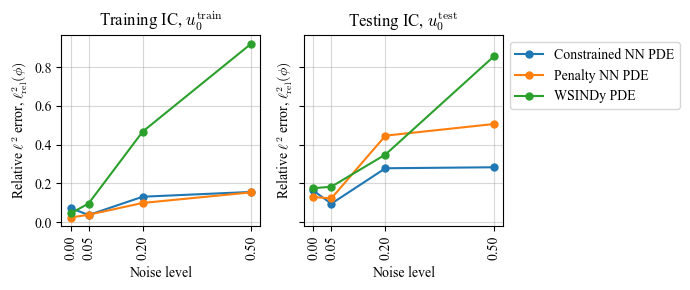

In [55]:
plt.style.use('../figs/paper.mplstyle')
save_fig_size = (7.0, 3.0)
# save_fig_size = (7.0, 4.5)

markers = {'marker': 'o', 'markersize': 5}
# plt.figure(figsize=(8,3))
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=save_fig_size)
ax[0].plot(noise_levels, l2s[:, 0], label='Constrained NN PDE', **markers)
ax[0].plot(noise_levels, l2s[:, 2], label='Penalty NN PDE', **markers)
ax[0].plot(noise_levels, l2s[:, 4], label='WSINDy PDE', **markers)
ax[1].plot(noise_levels, l2s[:, 1], label='Constrained NN PDE', **markers)
ax[1].plot(noise_levels, l2s[:, 3], label='Penalty NN PDE', **markers)
ax[1].plot(noise_levels, l2s[:, 5], label='WSINDy PDE', **markers)
for a in ax:
    a.set_xlabel('Noise level')
    a.set_ylabel(r'Relative $\ell^2$ error, $\ell^2_\text{rel} (\phi)$')
    a.set_xticks(noise_levels)
    # a.set_yscale('log')
    a.grid(True, which='both', alpha=0.5)
    # rotate x ticks
    a.set_xticklabels([f'{nl:.2f}' for nl in noise_levels], rotation=90)
ax[0].set_title(r'Training IC, $u^{\text{train}}_0$')
ax[1].set_title(r'Testing IC, $u^{\text{test}}_0$')
plt.legend(loc = 'upper left', bbox_to_anchor = (1.0, 1.0))
# ax[0].legend(loc = 'upper left')
# change x ticks to show the noise levels
# plt.ylim([1e-2, 1.0])

plt.tight_layout()
# set figure size
plt.gcf().set_size_inches(save_fig_size)
plt.savefig(f'../figs/{ic}_con_vs_pen_vs_wsindy_noise.pdf', bbox_inches='tight')